# Лабораторна робота №10. Transfer Learning

**Тема:** Класифікація зображень за допомогою Transfer Learning (MobileNetV2).

**Мета:** Навчитися використовувати попередньо натреновані моделі (TensorFlow Hub) для вирішення задачі бінарної класифікації методом Feature Extraction та Fine-Tuning.

**Датасет:** Власний набір даних (Pizza vs Burger).

In [1]:
!pip install tf_keras

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-hub

Defaulting to user installation because normal site-packages is not writeable


In [3]:

!pip install tf_keras

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)

Defaulting to user installation because normal site-packages is not writeable



C:\Users\HP Victus\AppData\Roaming\Python\Python313\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


TensorFlow version: 2.20.0


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Налаштування шляхів (використовуємо ті ж папки, що і в Лаб 9)
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'

# MobileNetV2 вимагає саме такий розмір [cite: 69]
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Бібліотеки завантажено.")

Бібліотеки завантажено.


In [5]:
# Нормалізація (MobileNetV2 любить значення від 0 до 1 або -1 до 1)
# Ми використовуємо 1./255, як найпростіший варіант
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # Трохи поворотів не завадить
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("--- Train Data ---")
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print("\n--- Test Data ---")
test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

--- Train Data ---
Found 91 images belonging to 2 classes.



--- Test Data ---
Found 40 images belonging to 2 classes.


## Етап 1: Feature Extraction (Виділення ознак)
Ми завантажуємо модель **MobileNetV2** з TensorFlow Hub. 
Всі її шари ми "заморожуємо" (`trainable=False`), щоб не зіпсувати те, що вона вже знає. 
[cite_start]Ми навчаємо тільки "голову" (останній шар), який буде класифікувати саме наші піци та бургери[cite: 18, 19].

In [6]:
# URL моделі MobileNetV2 (Feature Vector) [cite: 74]
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Завантаження шару Hub
feature_extractor_layer = hub.KerasLayer(
    model_url,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    trainable=False
)

model = models.Sequential([
    feature_extractor_layer,
    layers.Dense(1, activation='sigmoid') # 1 нейрон для бінарної класифікації
])

# Компіляція
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [7]:

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5



3/3 [==============================] - 12s 3s/step - loss: 0.7954 - accuracy: 0.4725 - val_loss: 1.0056 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 0.7305 - accuracy: 0.5275 - val_loss: 1.1547 - val_accuracy: 0.5250
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 0.6608 - accuracy: 0.5604 - val_loss: 1.3072 - val_accuracy: 0.4500
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 0.6410 - accuracy: 0.6264 - val_loss: 1.4487 - val_accuracy: 0.4250
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 0.5782 - accuracy: 0.7143 - val_loss: 1.5817 - val_accuracy: 0.3750


## Етап 2: Fine-Tuning (Донавчання)
Тепер ми "розморожуємо" базову модель, щоб вона могла трохи підлаштуватися під специфіку наших фотографій їжі.
[cite_start]**Важливо:** Ми використовуємо дуже маленький `learning_rate` (1e-5), щоб не "зламати" ваги моделі[cite: 28, 84].

In [8]:
# Розморожуємо базовий шар [cite: 82]
feature_extractor_layer.trainable = True

# Компілюємо знову з ДУЖЕ МАЛИМ кроком навчання (Low Learning Rate)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # [cite: 84]
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Починаємо Fine-Tuning...")

# Донавчаємо ще 5 епох
history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Починаємо Fine-Tuning...
Epoch 1/5
3/3 [==============================] - 19s 3s/step - loss: 1.0330 - accuracy: 0.5055 - val_loss: 1.6914 - val_accuracy: 0.4000
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 1.0215 - accuracy: 0.5275 - val_loss: 1.7218 - val_accuracy: 0.4000
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 0.9668 - accuracy: 0.4945 - val_loss: 1.7530 - val_accuracy: 0.4000
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.9318 - accuracy: 0.5165 - val_loss: 1.7864 - val_accuracy: 0.4000
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 0.9089 - accuracy: 0.5055 - val_loss: 1.8172 - val_accuracy: 0.4000


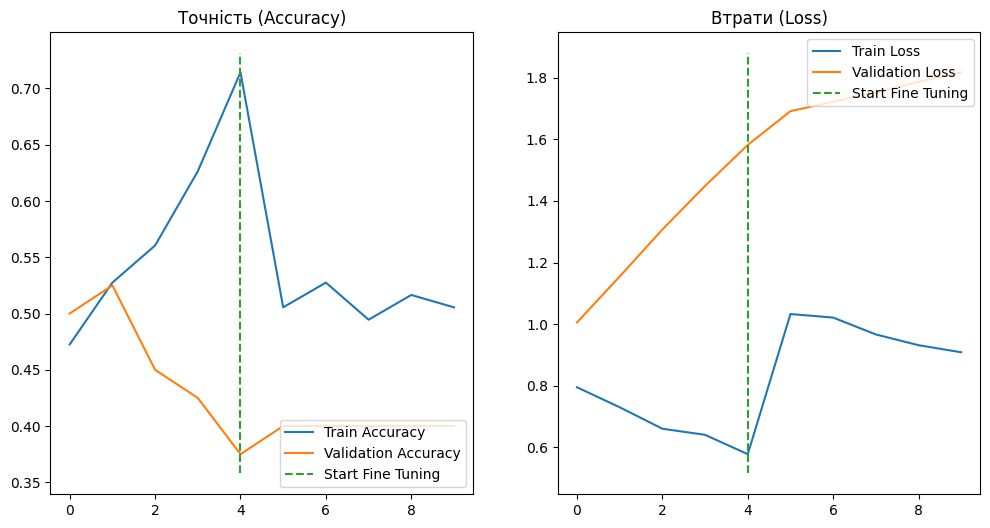

In [9]:
# Об'єднуємо історії навчання (щоб намалювати красивий графік)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Малюємо лінію, де почався Fine-Tuning
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Точність (Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')
plt.show()

2/2 [==============================] - 2s 434ms/step
              precision    recall  f1-score   support

      burger       0.44      0.80      0.57        20
       pizza       0.00      0.00      0.00        20

    accuracy                           0.40        40
   macro avg       0.22      0.40      0.29        40
weighted avg       0.22      0.40      0.29        40



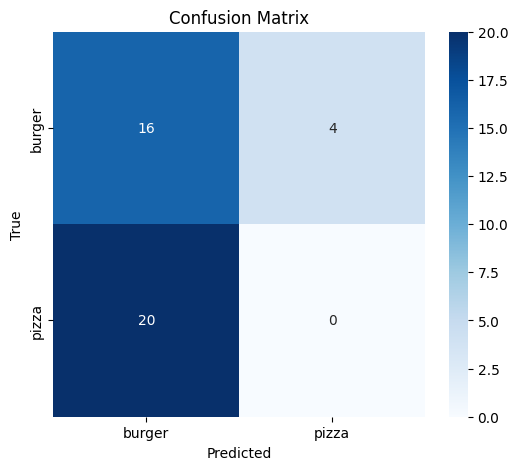

In [10]:
# Отримання прогнозів
test_data.reset()
predictions = model.predict(test_data, steps=len(test_data))
y_pred = (predictions > 0.5).astype("int32")
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Звіт [cite: 51]
print(classification_report(y_true, y_pred, target_names=class_labels))

# Матриця помилок [cite: 90]
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()